### Tf-idf를 사용한 분류기

In [11]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

# 데이터 로드
data = pd.read_csv("news_data.csv")

# 데이터 전처리 
data['tokenized_text'] = data['title'].apply(word_tokenize)

# 훈련 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(data['title'], data['category'], test_size=0.3)

# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# 나이브 베이즈 모델 초기화 및 훈련
model = MultinomialNB()
model.fit(X_train_vec, y_train)

# 모델 평가
y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          경제       1.00      1.00      1.00       102
          사회       1.00      1.00      1.00        24
          세계       1.00      1.00      1.00        61
          정치       1.00      1.00      1.00        53

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240



In [29]:
# 임의의 실패 데이터 생성
fail_data = pd.DataFrame({
    'title': ['이것은 실패할 테스트입니다'] * 100,  # 모델이 분류할 수 없는 텍스트
    'category': ['실패'] * 100  # 존재하지 않는 카테고리
})
# X_test_fail을 pandas Series로 변환
X_test_fail = pd.Series(X_test_fail)

# 문자열 데이터가 아닌 항목을 문자열로 변환
X_test_fail = X_test_fail.astype(str)

# TF-IDF 벡터화
X_test_vec_fail = vectorizer.transform(X_test_fail)

# 모델 평가 (실패 데이터 포함)
y_pred_fail = model.predict(X_test_vec_fail)
print(classification_report(y_test_fail, y_pred_fail))


              precision    recall  f1-score   support

          경제       0.28      1.00      0.44        95
          사회       0.00      0.00      0.00        27
          세계       0.00      0.00      0.00        70
          실패       0.00      0.00      0.00       100
          정치       0.00      0.00      0.00        48

    accuracy                           0.28       340
   macro avg       0.06      0.20      0.09       340
weighted avg       0.08      0.28      0.12       340



C:\Users\endnj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\endnj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\endnj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
X_train

789               중국 옷·일장기 연상 그림…오해 부른 한국 재외공관
633          '한국 노쇼' 호날두가 또…"중국 팬들, 미안" 이번엔 사과
132    미국 WSJ ‘김건희 2200달러 디올백’ 보도…“한국 여당 뒤흔들다”
126                      한국거래소, 신임 이사장에 정은보 추대
795       [단독] 3주간 아파트 공급 멈춘다…청약홈 개편에 건설사 '당혹'
                        ...                   
368       최태원, 주한외국상의 대표들에 "한국경제 일원으로 뭉치자"(종합)
340             24개국, 미·영 후티 추가공습 지지 성명…한국도 포함
201            [속보] 개혁신당 이준석·한국의희망 양향자 “합당” 선언
93           '한국 노쇼' 호날두가 또…"중국 팬들, 미안" 이번엔 사과
793          '한국 노쇼' 호날두가 또…"중국 팬들, 미안" 이번엔 사과
Name: title, Length: 560, dtype: object

In [13]:
X_test

210             24개국, 미·영 후티 추가공습 지지 성명…한국도 포함
588       최태원, 주한외국상의 대표들에 "한국경제 일원으로 뭉치자"(종합)
418       최태원, 주한외국상의 대표들에 "한국경제 일원으로 뭉치자"(종합)
230             24개국, 미·영 후티 추가공습 지지 성명…한국도 포함
460             24개국, 미·영 후티 추가공습 지지 성명…한국도 포함
                        ...                   
206                      한국거래소, 신임 이사장에 정은보 추대
31             [속보] 개혁신당 이준석·한국의희망 양향자 “합당” 선언
471            [속보] 개혁신당 이준석·한국의희망 양향자 “합당” 선언
736                      한국거래소, 신임 이사장에 정은보 추대
512    미국 WSJ ‘김건희 2200달러 디올백’ 보도…“한국 여당 뒤흔들다”
Name: title, Length: 240, dtype: object

In [14]:
y_train

789    사회
633    세계
132    세계
126    경제
795    경제
       ..
368    경제
340    세계
201    정치
93     세계
793    세계
Name: category, Length: 560, dtype: object

In [15]:
y_test

210    세계
588    경제
418    경제
230    세계
460    세계
       ..
206    경제
31     정치
471    정치
736    경제
512    세계
Name: category, Length: 240, dtype: object

#### example_text에 원하는 제목을 입력해 예측 결과 확인

In [16]:
example_text = "EU, 반도체·AI 등 민감기술 투자·수출 통제 추진"

# 전체 텍스트에 대한 벡터 변환
example_text_vec = vectorizer.transform([example_text])  # 리스트로 감싸서 전달

# 예측 수행
predicted_category = model.predict(example_text_vec)

print(f"제목: {example_text} \n예측된 카테고리: {predicted_category[0]}")

제목: EU, 반도체·AI 등 민감기술 투자·수출 통제 추진 
예측된 카테고리: 경제


Multinomial Naive Bayes 모델은 각 클래스에 대한 각 단어의 로그 조건부 확률을 feature_log_prob_ 속성에 저장한다.  
이 값을 사용하여 각 클래스에 대한 가장 중요한 단어들을 확인해보자.

In [17]:
import numpy as np

# TF-IDF 벡터라이저의 특성 이름 가져오기
feature_names = vectorizer.get_feature_names_out()

# 각 클래스에 대한 상위 N개 중요 단어를 추출하는 함수
def top_n_words_per_class(class_index, n=10):
    sorted_indices = model.feature_log_prob_[class_index, :].argsort()[::-1]
    top_n = feature_names[sorted_indices][:n]
    return top_n

# 각 클래스에 대한 상위 단어들 출력
for i in range(len(model.classes_)):
    class_name = model.classes_[i]
    top_words = top_n_words_per_class(i, 10)
    print(f"Class: {class_name}")
    print(f"Top words: {', '.join(top_words)}\n")


Class: 경제
Top words: 정은보, 추대, 이사장에, 신임, 한국거래소, 일원으로, 종합, 주한외국상의, 최태원, 대표들에

Class: 사회
Top words: 부른, 재외공관, 일장기, 연상, 오해, 그림, 중국, 한국, 보도, 뒤흔들다

Class: 세계
Top words: 한국, 후티, 한국도, 지지, 추가공습, 포함, 24개국, 성명, 노쇼, 이번엔

Class: 정치
Top words: 양향자, 한국의희망, 이준석, 선언, 개혁신당, 합당, 속보, 성명, 사과, 뒤흔들다



In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

# 데이터 로드 및 전처리
data = pd.read_csv("news_data.csv")

# 파이프라인 생성: TF-IDF 벡터화 및 나이브 베이즈 모델
pipeline = make_pipeline(TfidfVectorizer(), MultinomialNB())

# 교차 검증 수행
cross_val_scores = cross_val_score(pipeline, data['title'], data['category'], cv=10, scoring='accuracy')

# 교차 검증 결과 출력
print("교차 검증 정확도 점수:", cross_val_scores)
print("평균 정확도:", np.mean(cross_val_scores))


교차 검증 정확도 점수: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
평균 정확도: 1.0


### Word2Vec를 사용한 분류기

In [19]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 데이터 로드 및 전처리
data = pd.read_csv("news_data.csv")

data['tokenized_text'] = data['title'].apply(word_tokenize)
# Word2Vec 모델 훈련
w2v_model = Word2Vec(data['tokenized_text'], vector_size=100, window=5, min_count=1, workers=4)

# 문서별 평균 벡터 계산 함수
def document_vector(doc):
    # 단어 벡터의 평균을 계산
    doc = [word for word in doc if word in w2v_model.wv.index_to_key]
    return np.mean(w2v_model.wv[doc], axis=0)

# 각 문서에 대한 문서 벡터 생성
data['doc_vector'] = data['tokenized_text'].apply(document_vector)

# 훈련 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(data['doc_vector'].tolist(), data['category'], test_size=0.3)

# 분류기 훈련
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

# 예측을 위한 함수 정의
def predict_category(text, w2v_model, classifier):
    # 텍스트를 토큰화하고 Word2Vec 모델을 사용하여 벡터 생성
    tokenized_text = text.split()
    doc_vector = document_vector(tokenized_text)
    if np.isnan(doc_vector).any():
        doc_vector = np.zeros(w2v_model.vector_size)
    
    # 예측 수행
    predicted_category = classifier.predict([doc_vector])
    return predicted_category[0]

# 모델 평가
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          경제       1.00      1.00      1.00        95
          사회       1.00      1.00      1.00        27
          세계       1.00      1.00      1.00        70
          정치       1.00      1.00      1.00        48

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240



In [23]:
X_train

[array([ 2.19681095e-02,  7.65163302e-02, -6.48794174e-02, -5.63417561e-03,
         9.07241330e-02, -3.36408466e-01,  1.03220604e-01,  3.97545308e-01,
        -1.82769760e-01, -2.23140672e-01,  7.65067944e-03, -2.46258631e-01,
        -1.17347047e-01,  5.05939573e-02,  2.18709692e-01, -4.34956625e-02,
         4.99535352e-02, -1.25690088e-01, -7.96437338e-02, -3.61969203e-01,
         6.60502836e-02,  1.97509065e-01,  1.21989109e-01, -1.14575982e-01,
        -8.94645378e-02,  5.06950484e-04, -2.29468048e-01,  3.69720906e-02,
        -5.34510463e-02,  9.37607810e-02,  1.54103383e-01, -1.30386740e-01,
         2.35345036e-01, -4.09644395e-01, -1.01931736e-01,  2.22936809e-01,
         8.81339908e-02,  2.21168064e-03, -6.31442443e-02, -2.87870198e-01,
         9.83467996e-02, -1.44817248e-01, -3.62830125e-02,  9.03372392e-02,
         2.08861977e-01,  8.63231625e-03, -1.83478221e-01, -1.19837694e-01,
         1.07788518e-01,  7.31508061e-02,  7.31212199e-02, -1.38170794e-01,
        -4.8

In [24]:
X_test

[array([ 0.03380644,  0.05905453, -0.05531894, -0.00573885,  0.06263873,
        -0.33901167,  0.11188968,  0.38481113, -0.15591371, -0.22673926,
         0.01749655, -0.24532382, -0.1055908 ,  0.08694122,  0.18889481,
        -0.04295386,  0.02160196, -0.0903487 , -0.08985814, -0.3155854 ,
         0.08495013,  0.18142234,  0.13802129, -0.11625988, -0.07978894,
        -0.01095379, -0.19118209,  0.00496677, -0.05208978,  0.08911777,
         0.14758717, -0.13021909,  0.24827167, -0.40398443, -0.10396664,
         0.2192313 ,  0.0732469 ,  0.01681237, -0.07423767, -0.27422732,
         0.08753712, -0.11970079, -0.04079613,  0.05728719,  0.20466332,
         0.00889947, -0.16132131, -0.13300024,  0.12805736,  0.07422114,
         0.06272862, -0.13974825, -0.06175623, -0.09821216,  0.0199372 ,
         0.00266568,  0.11892159, -0.02095554, -0.08386575, -0.00590772,
         0.02582765, -0.02754932,  0.07373875,  0.03732453, -0.080246  ,
         0.3466868 ,  0.06793476,  0.20498101, -0.3

In [25]:
y_train

745    경제
582    세계
110    세계
483    세계
645    경제
       ..
349    사회
148    경제
441    정치
570    세계
83     세계
Name: category, Length: 560, dtype: object

In [26]:
y_test

180    세계
55     경제
496    경제
480    세계
594    정치
       ..
541    정치
694    정치
548    경제
558    경제
614    정치
Name: category, Length: 240, dtype: object

Word2Vec 모델은 훈련 데이터에 있는 단어들만 학습한다. 만약 예측하려는 텍스트에 훈련 데이터에 없는 새로운 단어가 포함되어 있다면, 이 단어들은 Word2Vec 모델에 의해 벡터로 변환되지 않기 때문에, 제대로 예측하지 못하거나 에러가 나온다.
즉 뉴스 제목으로 카테고리를 예측하는 모델을 만들 때 Word2Vec 모델을 사용한다면, 뉴스 제목에 어떤 단어가 들어와도 그 단어가 훈련 데이터 안에 있어야 하도록 어마어마한 양의 훈련 데이터가 필요하다는 뜻이다.

In [20]:
#제목에 있는 단어가 학습 데이터에 모두 있는 경우
example_text_1 = "24개국, 미·영 후티 추가공습 지지 성명…한국도 포함"
predicted_category_1 = predict_category(example_text_1, w2v_model, classifier)
print(f"제목: {example_text_1} \n예측된 카테고리: {predicted_category_1}")

# #제목에 학습 데이터에 없는 단어가 있는 경우 - ValueError: need at least one array to concatenate
# example_text_2 = "한국원자력학회, 고준위 방폐물 특별법 처리 촉구"
# predicted_category_2 = predict_category(example_text_2, w2v_model, classifier)
# print(f"제목: {example_text_2} \n예측된 카테고리: {predicted_category_2}")

제목: 24개국, 미·영 후티 추가공습 지지 성명…한국도 포함 
예측된 카테고리: 세계


Word2Vec에서 각 특성은 Word2Vec 모델에 의해 생성된 개별 차원(word -> vector)을 나타내기 때문에, 카테고리 결정에 영향을 미치는 구체적인 단어를 파악하고자 한다면 TF-IDF를 사용해야 한다.

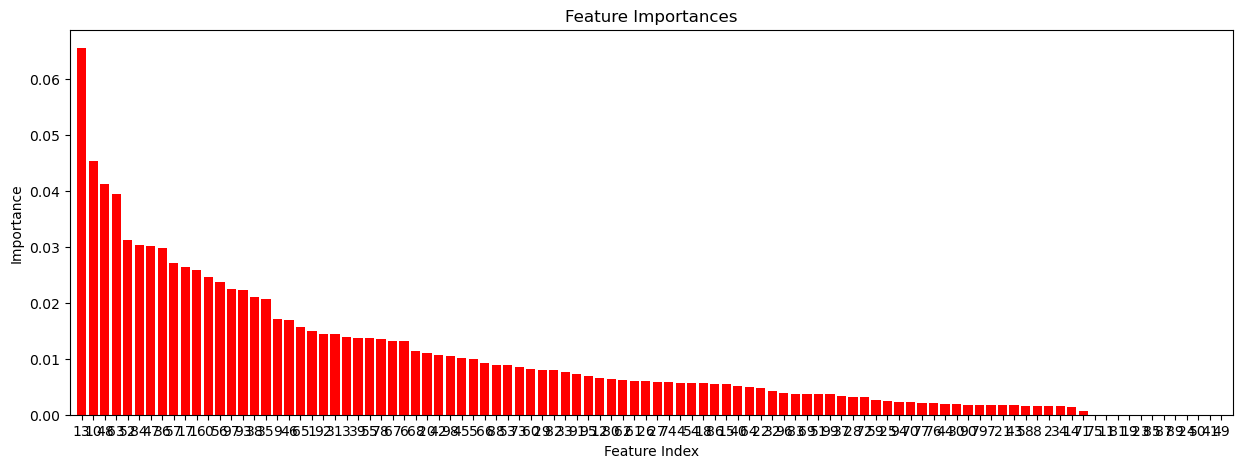

In [21]:
import matplotlib.pyplot as plt

# RandomForestClassifier의 feature importance 추출
importances = classifier.feature_importances_

# feature importance를 시각화
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(15, 5))
plt.title("Feature Importances")
plt.bar(range(len(indices)), importances[indices], color="r", align="center")
plt.xticks(range(len(indices)), indices)
plt.xlim([-1, len(indices)])
plt.xlabel('Feature Index') #xlabel 이 단어가 아닌 벡터로 나온다.
plt.ylabel('Importance')
plt.show()

In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

#전체 문서 벡터를 NumPy 배열로 변환
X = np.array(data['doc_vector'].tolist())
y = data['category']

# RandomForestClassifier 초기화
classifier = RandomForestClassifier()

# 교차 검증 실행 (예: 5-폴드 교차 검증)
scores = cross_val_score(classifier, X, y, cv=10)

# 평균 정확도 출력
print("교차 검증 정확도:", scores)
print("평균 정확도:", np.mean(scores))

교차 검증 정확도: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
평균 정확도: 1.0
